# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In [83]:
# import libs 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import flatten
import tensorflow as tf
from sklearn.utils import shuffle
import cv2
from PIL import Image
import requests 
from io import BytesIO

---
## Step 0: Load The Data

The traffic sign images are from Data Resource: [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [84]:
# Load pickled data

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [85]:

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_test)[1:-1]

# TODO: How many unique classes/labels there are in the dataset.
all_sign_labels = np.unique(y_train)
n_classes = len(all_sign_labels)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

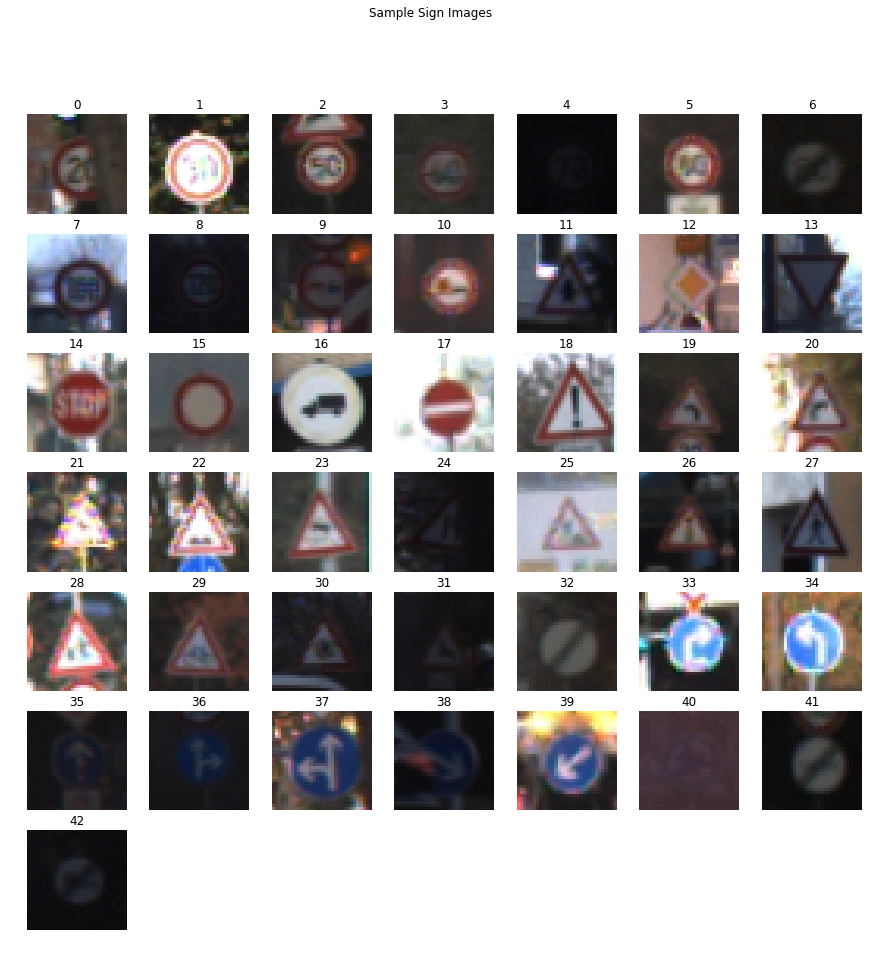

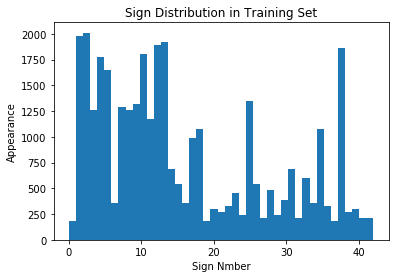

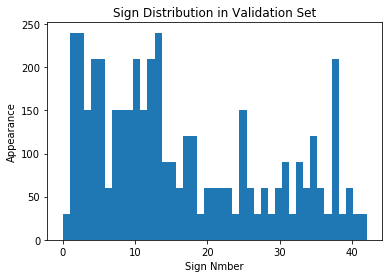

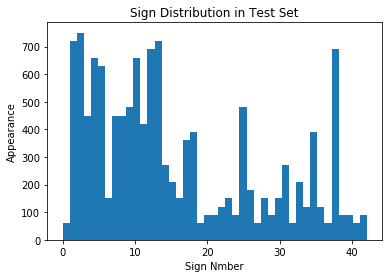

In [86]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.


plt.figure(figsize=(15,15))
plt.suptitle('Sample Sign Images')
# sample sign image for each label 
for each_label in sorted(list(all_sign_labels)):
    img_idx = list(y_valid).index(each_label)
    plt.subplot(7,7,each_label+1)
    plt.title(each_label)
    plt.axis('off')
    plt.imshow(np.squeeze(X_valid[img_idx]))
        
# distribution of the data sets 
COMMON_X_LABEL = 'Sign Nmber'
COMMON_Y_LABEL = 'Appearance'
plt.figure()
plt.hist(y_train,bins=n_classes)
plt.xlabel(COMMON_X_LABEL)
plt.ylabel(COMMON_Y_LABEL)
plt.title('Sign Distribution in Training Set')

plt.figure()
plt.hist(y_valid,bins=n_classes)
plt.xlabel(COMMON_X_LABEL)
plt.ylabel(COMMON_Y_LABEL)
plt.title('Sign Distribution in Validation Set')

plt.figure()
plt.hist(y_test,bins=n_classes)
plt.ylabel(COMMON_Y_LABEL)
plt.xlabel(COMMON_X_LABEL)
plt.title('Sign Distribution in Test Set')

plt.show()

Sample images of all sign in the data set are shown in figure, sample sign images. The distribution of each sign is different in the data set as shown in the distribution plot.

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

All given images are converted to grayscale at first and then using the average pixel value of all images as the pivot; the pixels value is regularized by 

reg_pix = (unreg_pix – pix_avg)/pix_avg.

In [87]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
PIX_AVG = np.mean(X_train)
def toGrayAndRegularize(image_array):
    '''
    convert the image to gray and then regularize
    v_reg = (v_ureg/255) - 0.5
    return: array of regularized gray image 
    '''
    global PIX_AVG
    ori_shape = list(np.shape(image_array))
    ori_shape[-1] = 1
    gray_shape = tuple(ori_shape)
    output = np.empty(shape = gray_shape)
    for idx in range(len(image_array)):
        cur_img = image_array[idx]
        gray_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
        cvt_img = gray_img
        cvt_img = (cvt_img - PIX_AVG)/PIX_AVG
        expand_shape = cvt_img[:,:,np.newaxis]
        output[idx] = expand_shape
    return output


# process the input data sets, train, valid, test 
X_train = toGrayAndRegularize(X_train)
X_valid = toGrayAndRegularize(X_valid)
X_test = toGrayAndRegularize(X_test)

### Model Architecture

LeNet neural network architecture from the lesson [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) is modified and used for the traffic sign recognition task. The detail for each layer are as follows:
1.	
    -	Input: (32,32,1) regularized grayscale images 
    -	Filter size: (5, 5, 1, 6)
    -	Strid: (1,1)
2.	
    -	Input: (28,28,6)
    -	Max pooling
3.	
    -	Input: (14,14,6)
    -	Filter size: (5,5,6,16)
    -	Strid: 1 
4.	
    -	Input: (10,10,16)
    -	Max pooling
5.	
    -	Fully Connected input: 400
    -	Output: 300
6.	
    -	Fully Connected input: 300
    -	Output: 200
7.	
    -	Fully Connected: 200
    -	Output: 50
8.	
    -	Fully Connected: 50
    -	Output: number of Classes 

Same architecture with exact number of input size and output size for each layer as described in the tutorial is attempted at the beginning, as LeNet proves its effectiveness in digit recogonition task which is very similar to traffic sign recognition. However, it is observed that the performance is not satisfactory. To improve the model performance, the input size of each layer is increased to enable the network to capture more complicate details, but not too many that will cause overfitting. The output size of the final layer is also increased to 43 according to the number of the traffic sign needed to recognized. 

In [88]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #   Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #   Activation.
    conv1 = tf.nn.sigmoid(conv1)

    #   Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #   Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #   Activation.
    conv2 = tf.nn.sigmoid(conv2)

    #   Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #   Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #   Layer 3: Fully Connected. Input = 400. Output = 300
    l3_out = 300
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, l3_out), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(l3_out))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #   Activation.
    fc1    = tf.nn.sigmoid(fc1)

    #   Layer 4: Fully Connected. Input = 300. Output = 200,
    l4_out = 200
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(l3_out, l4_out), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(l4_out))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #   Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected, input = 200, output = 100
    l5_out = 50
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(l4_out, l5_out), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(l5_out))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b

    #   Layer 5: Fully Connected. Input = 100. Output = n_classes.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(l5_out, n_classes), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

101 epochs with a batch size of 200 are used to train the neural network. Adam algorithm is used for the optimization process. Compared with the simple gradient descent algorithm, the Adam algorithm uses momentum and controls the learning rate to converge faster.


In [89]:
### Train your model here.
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)



rate = 0.00085
EPOCHS = 101
BATCH_SIZE = 200

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

save_model_address = './lenet'
record_x = []
record_train = []
record_valid = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_train, y_train)
        record_x.append(i)
        record_train.append(training_accuracy)
        record_valid.append(validation_accuracy)
        if i%30 == 0:
            print("EPOCH {} ...".format(i+1))
            print("Training Accuracy = {:.3f}".format(training_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        if validation_accuracy >= 0.93:
            print("EPOCH {} ...".format(i+1))
            print("Training Accuracy = {:.3f}".format(training_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            break
        
    saver.save(sess, save_model_address)
    print("Model saved")
    

Training...

EPOCH 1 ...
Training Accuracy = 0.103
Validation Accuracy = 0.083

EPOCH 31 ...
Training Accuracy = 0.979
Validation Accuracy = 0.908

EPOCH 61 ...
Training Accuracy = 0.997
Validation Accuracy = 0.924

EPOCH 79 ...
Training Accuracy = 1.000
Validation Accuracy = 0.931

Model saved


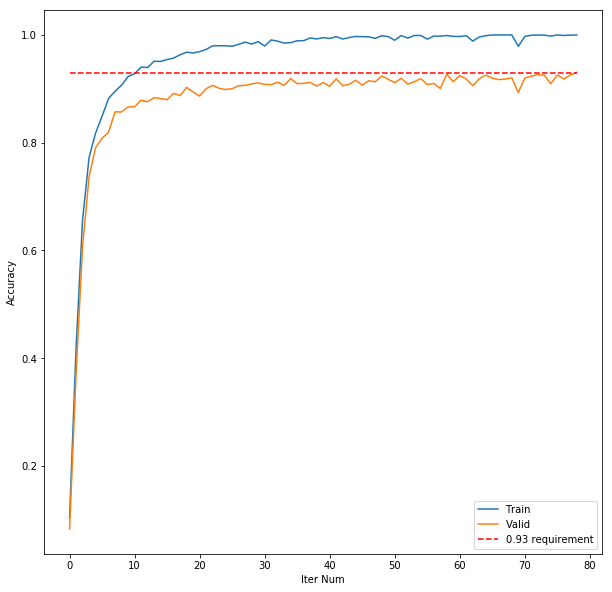

In [90]:
plt.figure(figsize=(10,10))
plt.plot(record_x, record_train)
plt.plot(record_x, record_valid)
plt.plot(record_x, 0.93 * np.ones_like(record_x), 'r--')
plt.legend(['Train', 'Valid', '0.93 requirement'])
plt.xlabel('Iter Num')
plt.ylabel('Accuracy')
plt.show()

As shown in the plot of the accuracy plot, with the increase of trainning accuracy, the validation accuracy does not decrease which proves overfitting does not appear in the model. 
As shown in the result, when the validation accuracy reaches 0.93, the trainning accuracy is 1 for the training data set.

### Test The Model 

In [91]:
### Load the images and plot them here.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.913


The high test accuracy of 0.913 on the test set proves that the trained model can recognize traffic sign well on the images processed by the samiliar technique used in the given data set. 

---

## Step 3: Test a Model on New Images

### Load and Output the Images

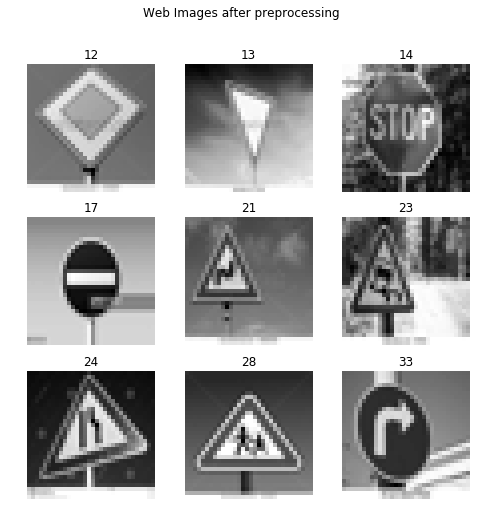

In [92]:
# Preprocess the webImages by changing its size, no cropping     
def webImageToRegGray(url_string):
    '''
    return a image from a url and resize the image 
    '''
    response = requests.get(url_string)
    img = Image.open(BytesIO(response.content))
    img = img.resize((32,32), Image.BICUBIC)
    gray_img = cv2.cvtColor(np.array(img),cv2.COLOR_RGB2GRAY)
    gray_img = (gray_img - PIX_AVG)/PIX_AVG
    expand_shape = gray_img[:,:,np.newaxis]
    return expand_shape

web_pic_dict = {14: 'http://aopastake.org/wp-content/uploads/2015/01/Stop-sign.jpg',
                21: 'https://thumb1.shutterstock.com/display_pic_with_logo/3869111/369902984/stock-photo-dutch-road-sign-double-bend-first-to-right-369902984.jpg',
                28: 'https://image.shutterstock.com/display_pic_with_logo/60395/60395,1217349674,4/stock-vector-warning-children-on-road-sign-illustration-15493621.jpg',
                24: 'https://thumbs.dreamstime.com/z/road-narrows-right-german-sign-79806088.jpg',
                17: 'http://media.gettyimages.com/vectors/no-entry-german-road-sign-vector-id452240089?s=170667a',
                33: 'http://cdn.xl.thumbs.canstockphoto.com/canstock23189668.jpg',
                23: 'http://l450v.alamy.com/450v/cf48a4/a-rural-slippery-road-sign-with-a-snow-covered-road-in-the-background-cf48a4.jpg',
                12: 'https://thumb1.shutterstock.com/display_pic_with_logo/3869111/474783337/stock-photo-german-road-sign-priority-road-474783337.jpg',
                13: 'http://l7.alamy.com/zooms/b17e9efa0ff24fa8904bc67cf1263500/yield-sign-e7p3gk.jpg'}

X_real = np.empty([len(web_pic_dict), 32,32,1])
y_real = np.array(sorted([key for key in web_pic_dict.keys()]))

plt.figure(figsize=(8,8))
plt.suptitle('Web Images after preprocessing')
for idx in range(len(y_real)):
    cur_label = y_real[idx]
    cur_url = web_pic_dict[cur_label]
    cur_img = webImageToRegGray(cur_url)
    plt.subplot(3,3,idx+1)
    plt.imshow(np.squeeze(cur_img),cmap='gray')
    plt.title(cur_label)
    plt.axis('off')
    X_real[idx] = cur_img
plt.show()

9 images not from the given dataset are used to test the accuracy of the train network in the real world. As the image from other resource has a different format than the ones in the given data set, those new images are resized and formatted before tested using the trained model.

### Predict the Sign Type for Each Image

In [93]:
# Accuracy on real images from other resources 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    real_acc = evaluate(X_real, y_real)
    print("Real Accuracy = {:.3f}".format(real_acc))

INFO:tensorflow:Restoring parameters from .\lenet
Real Accuracy = 0.333


### Analyze Performance

Out of the 9 newly downloaded traffic sign pictures, the trained neural network is capable of recognizing 3 of them. Sign label 12, 13 and 14 are corrected labeled using the trained neural network.
Although the recognition of the image from other resources is low, it could be a result of different format of the image. As shown, the correctly recognized images have similar margins as the images in the given set. 
The other factor that possibly leads to the low recognition accuracy on the new images is that during the resizing process, a significant amount of information is lost. Additionally, that the resizing method used for the new images could be different from the method used in the given set might result in considerably different pixel values. 


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet


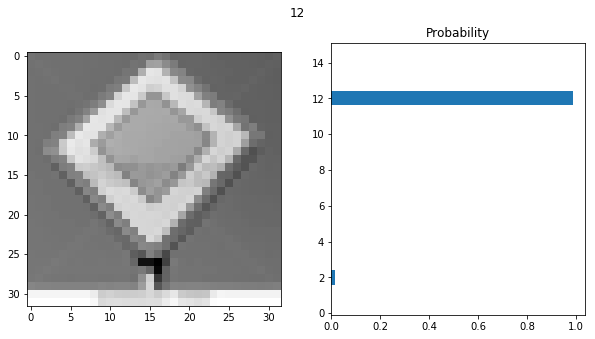

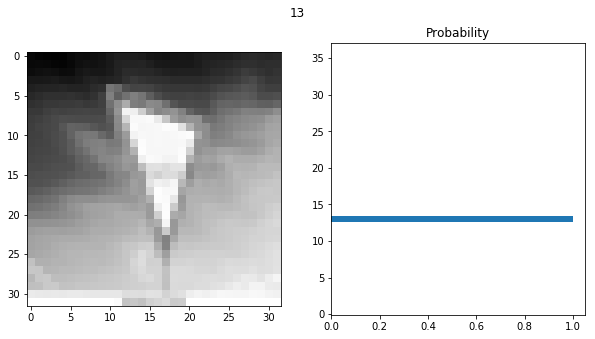

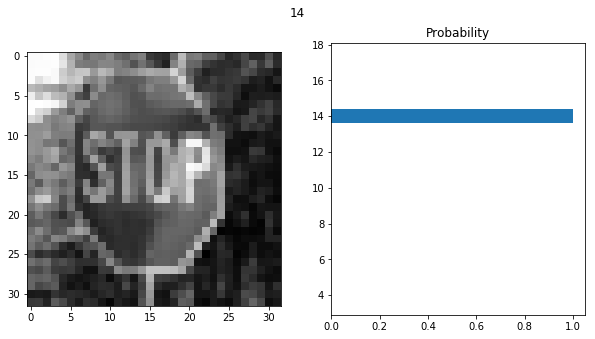

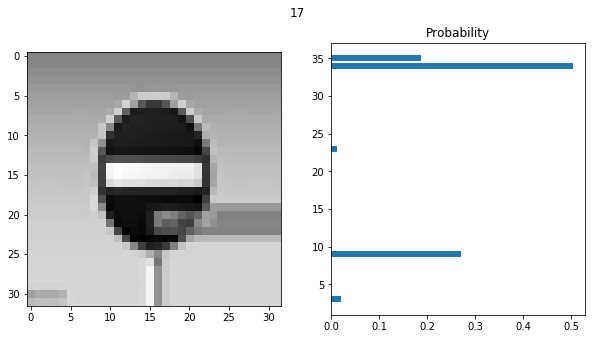

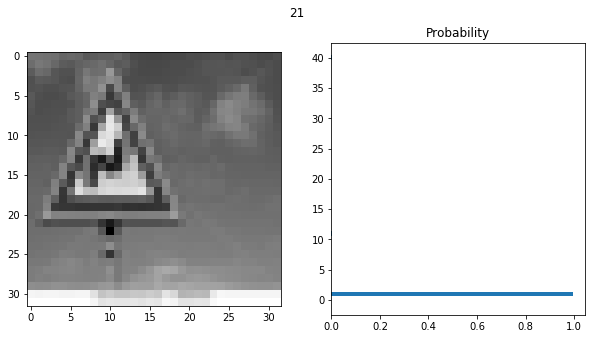

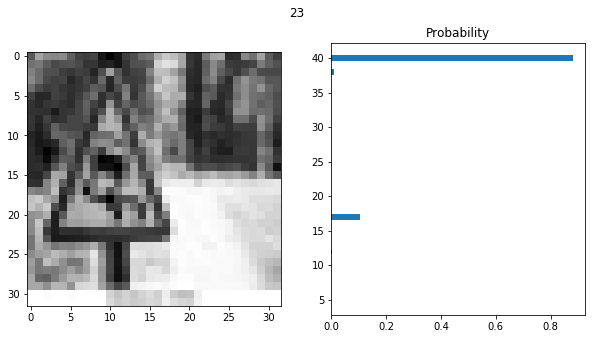

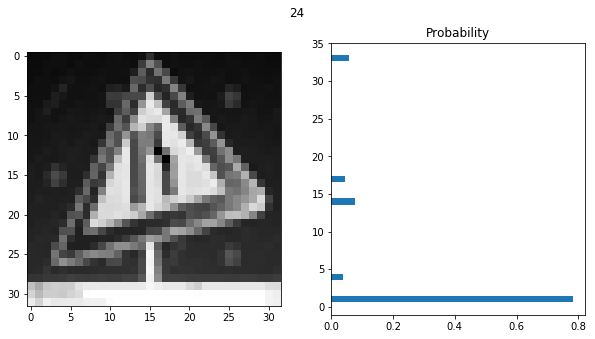

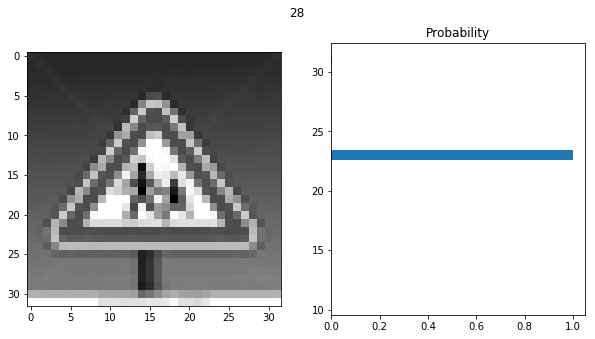

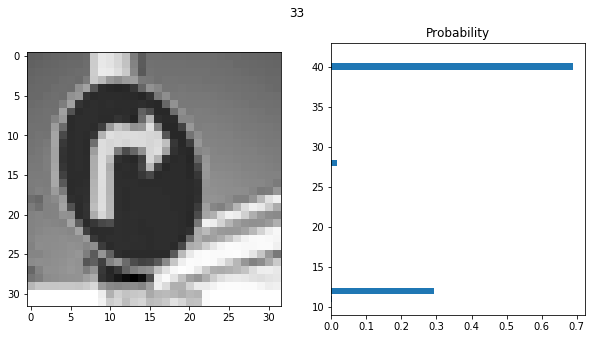

In [94]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
keep_prob = tf.placeholder(tf.float32)
def show_prob(X_data, sess): 
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_data, keep_prob: 1.0})    
    top_5 = tf.nn.top_k(prob, k=5)
    return sess.run(top_5)


with tf.Session() as sess:
    saver.restore(sess, './lenet')
    signs_top_5=show_prob(X_real, sess)
    for idx in range(len(signs_top_5[0])):
        plt.figure(figsize=(10,5))
        plt.suptitle(y_real[idx])
        plt.subplot(1,2,1)
        plt.imshow(np.squeeze(X_real[idx]), cmap='gray')
        plt.subplot(1,2,2)
        plt.title('Probability')
        plt.barh(signs_top_5[1][idx],signs_top_5[0][idx])
        plt.show()
